In [10]:
from helper_models import SteppedLogisticRegression
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
from scipy.special import expit
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import util
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        X, y, feature_names, n_features, n_samples = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


## Generate Data

In [4]:
n_samples = 1000
n_features = 1
feature_names = ['x1']
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)
X = X[:, np.newaxis]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

In [20]:
X_test = np.reshape(np.linspace(-5, 7, 300), (300, 1))

## Train Models

In [6]:
%%time
clf_a = LogisticRegression(C=1e5)
clf_a.fit(X, y)
clf_b = SteppedLogisticRegression(C=1e5)
clf_b.fit(X, y)
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 15 ms, sys: 4.59 ms, total: 19.6 ms
Wall time: 22.1 ms


## Analyze Results

In [23]:
margin_a = util.calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X_test))
margin_b = util.calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X_test))
loss_a = clf_a.predict_proba(X_test)[:, 1]
loss_b = clf_b.predict_proba(X_test)[:, 1]

divide by zero encountered in log


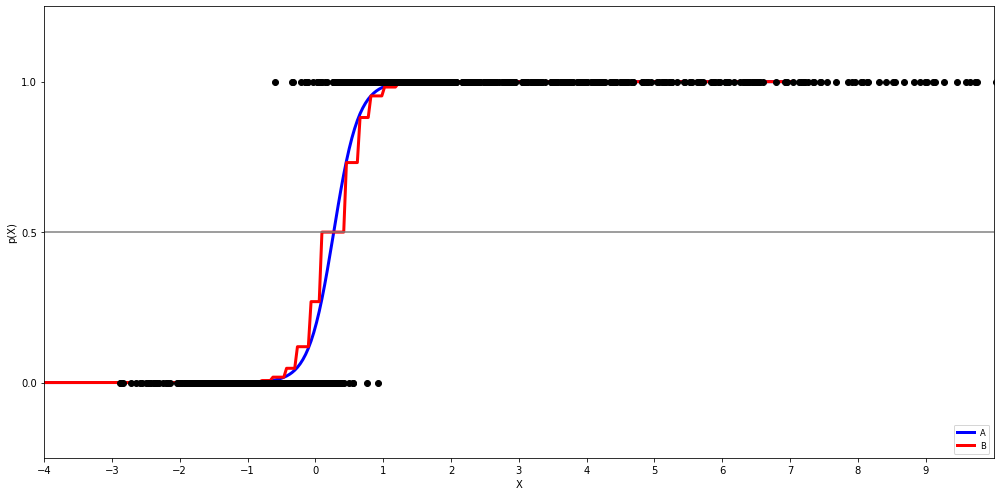

In [24]:
plt.figure(1, figsize=(7*2, 7))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
plt.plot(X_test, loss_a, color='blue', linewidth=3)
plt.plot(X_test, loss_b, color='red', linewidth=3)
plt.axhline(.5, color='.5')
plt.ylabel('p(X)')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('A', 'B'), loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

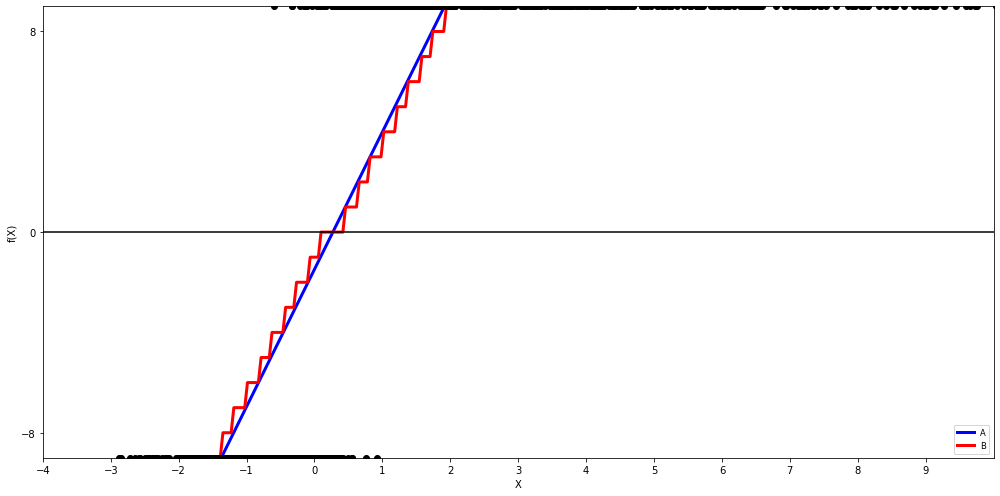

In [25]:
plt.figure(1, figsize=(7*2, 7))
plt.clf()
plt.scatter(X.ravel(), np.where(y == 1, 9, -9), color='black', zorder=20)
plt.plot(X_test, margin_a, color='blue', linewidth=3)
plt.plot(X_test, margin_b, color='red', linewidth=3)
plt.axhline(0, color='0')
plt.ylabel('f(X)')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([-8, 0, 8])
plt.ylim(-9, 9)
plt.xlim(-4, 10)
plt.legend(('A', 'B'), loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

## Visualize Distributions of Predictions

In [32]:
n_sample = X.shape[0]
indices = np.array(range(n_samples))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_odds_a = util.calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
log_odds_b = util.calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))

divide by zero encountered in log
divide by zero encountered in log


In [33]:
is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)

Instances with non-finite log-odds predictions:

In [34]:
pd.DataFrame(X[~is_finite]).describe()

,0
count,41.000000
mean,8.454640
std,1.049090
min,7.042070
25%,7.451620
50%,8.309066
75%,9.141235
max,10.930147


In [35]:
log_odds_a[~np.isfinite(log_odds_a)]

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf])

In [36]:
log_odds_b[~np.isfinite(log_odds_b)]

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf])

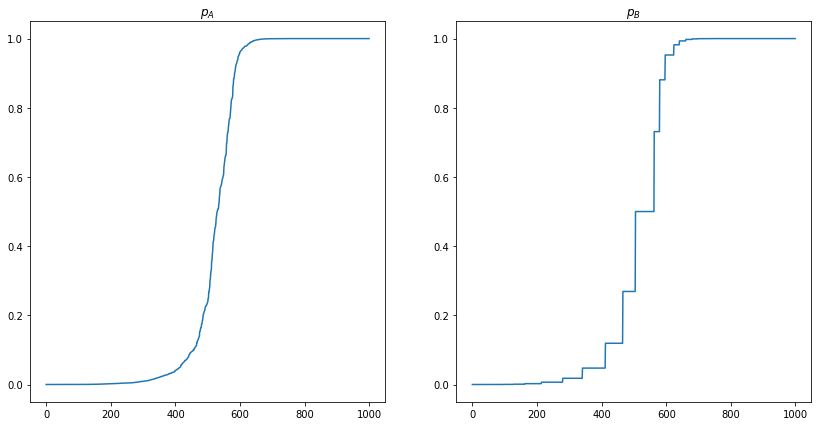

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

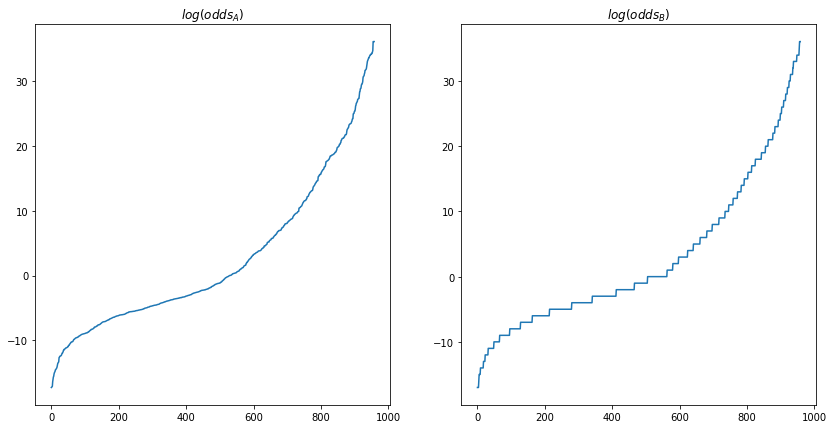

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

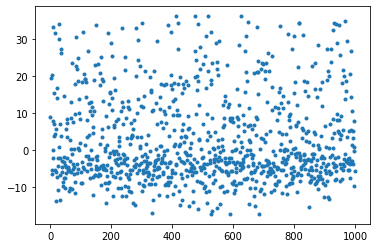

In [39]:
plt.scatter(indices, log_odds_a, marker='.');

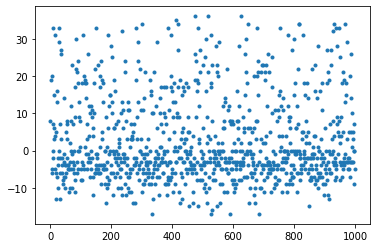

In [40]:
plt.scatter(indices, log_odds_b, marker='.');